In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import torch.nn.functional as F
import wandb
from torchvision.models import VisionTransformer
from pytorch_pretrained_vit import ViT


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
torch.manual_seed(20)

In [5]:
path = "../dataset/"
## Load the testing & training data from data_npy folder# Directory Names
dir_training = '{}/training'.format(path)
dir_testing = '{}/testing'.format(path)
file_name = ''

import gc
from torch.utils.data import Dataset, DataLoader
class ToothDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.dataset_path = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.dataset_path))

    def __getitem__(self, idx):
        global file_name
        if idx >= len(os.listdir(self.dataset_path)):
            print("No datafile/image at index : " + str(idx))
            return None
        npy_filename = os.listdir(self.dataset_path)[idx]
        
        file_name = npy_filename
        label = int('onlay' in npy_filename)
        numpy_arr = np.load(self.dataset_path + '/' + npy_filename)
        for i in range(numpy_arr.shape[0]-70):
            numpy_arr = np.delete(numpy_arr, [0], axis=0)
        numpy_arr = numpy_arr.reshape(1, 70, 70, 70)
        tensor_arr = torch.from_numpy(numpy_arr).to(torch.float32)

        del numpy_arr
        gc.collect()

        if self.transform:
            tensor_arr = self.transform(tensor_arr)  # Apply transformations
        print(npy_filename)
        return tensor_arr.to(torch.float32), torch.LongTensor([label])


In [6]:
# Hyperparameters
epochs = 500
batch_size = 1
learning_rate = 1e-5
weight_decay = 0.0000000001
momentum = 0.9
training_data = ToothDataset(img_dir=dir_training, transform=None)
validation_data = ToothDataset(img_dir=dir_testing, transform=None)


In [7]:
training_data_loader = DataLoader(training_data, batch_size, shuffle=True)
validation_data_loader = DataLoader(validation_data, batch_size, shuffle=False)


In [8]:
pretrained_model = ViT('B_16_imagenet1k', pretrained=True)
for param in pretrained_model.parameters():
    param.requires_grad = False


Loaded pretrained weights.


In [9]:
# Define the model architecture to generate saliency maps
# The following model is using "Data Preprocessing Method 1" from the paper, and is given in the paper's github repository
class NeuralNetwork(nn.Module):
    def __init__(self,):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=32,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(in_channels=32, out_channels=64,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(in_channels=64, out_channels=128,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(in_channels=128, out_channels=256,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(in_channels=256, out_channels=512,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),
            nn.Flatten(),
        )

        self.vit = pretrained_model
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.repeat(1, 36, 1, 1, 1)
        x = x.view(-1, 1, 384, 384)
        x = x.repeat(1, 3, 1, 1)
        # print(x.shape)
        x = self.vit(x)
        x = self.fc(x)
        return x


model = NeuralNetwork().to(device)


## load the model from the saved file
model.load_state_dict(torch.load(
    '../model.pt', map_location=torch.device('cpu')))


In [97]:
import gc
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
import torch
from captum.attr import Saliency
import meshio

threshold = 0.5


## generate saliency map for the given data and target
def generateAndSaveSaliencyMap(model, data, target):
    global threshold
    global file_name
    
    # Create a directory named the file_name without the extension if it doesn't exist
    if not os.path.exists(file_name[:-4]):
        os.makedirs(file_name[:-4])
        
    # store the directory path
    directory = file_name[:-4] + "/"
    
    #store the path of the file to be saved
    file_name = directory + file_name[:-4] + "_saliency_map.stl"

    # Generate saliency map
    saliency = Saliency(model)
    saliency_map = saliency.attribute(data, target=target)

    # Move saliency map to CPU and convert to numpy array
    saliency_map = saliency_map.cpu().detach().numpy().squeeze()

    # Calculate threshold value as the 70% percentile of the saliency map
    threshold = np.percentile(saliency_map, 99.5)
    # print(threshold)

    # Create a 3D isosurface from the saliency map
    verts, faces, _, _ = measure.marching_cubes(saliency_map, threshold)

    # Create a figure with a 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create a 3D isosurface from the saliency map
    mesh = Poly3DCollection(verts[faces], alpha=0.4)
    face_color = [1.0, 0.647, 0.0]  # color of the saliency map surface
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    # Create a 3D isosurface from the original data
    original_verts, original_faces, _, _ = measure.marching_cubes(
        data.cpu().detach().numpy().squeeze(), 120)

    # Create a 3D isosurface from the original STL file
    original_mesh = Poly3DCollection(original_verts[original_faces], alpha=0.4)
    original_face_color = [0.5, 0.5, 1]  # color of the original surface
    original_mesh.set_facecolor(original_face_color)
    ax.add_collection3d(original_mesh)

    # Set limits and labels of the plot
    max_dim = np.max(np.vstack([original_verts, verts]), axis=0)
    ax.set_xlim(0, max_dim[0])
    ax.set_ylim(0, max_dim[1])
    ax.set_zlim(0, max_dim[2])
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    
    meshio.write(file_name, meshio.Mesh(
        points=np.vstack([original_verts, verts]), cells=[("triangle", np.vstack([original_faces, faces+len(original_verts)]))]))
    
    # remove _saliency.stl and add .stl
    file_name = file_name[:-17] + ".stl"
    meshio.write(file_name, meshio.Mesh(
        points=verts, cells=[("triangle", faces)]))
    #remove the .stl and add _original.stl
    file_name = file_name[:-4] + "_original.stl"
    meshio.write(file_name, meshio.Mesh(
        points=original_verts, cells=[("triangle", original_faces)]))
    
    # Show the plot
    plt.show()

    # Free up memory
    del saliency_map, verts, faces, mesh, original_mesh
    gc.collect()


T1.1.npy


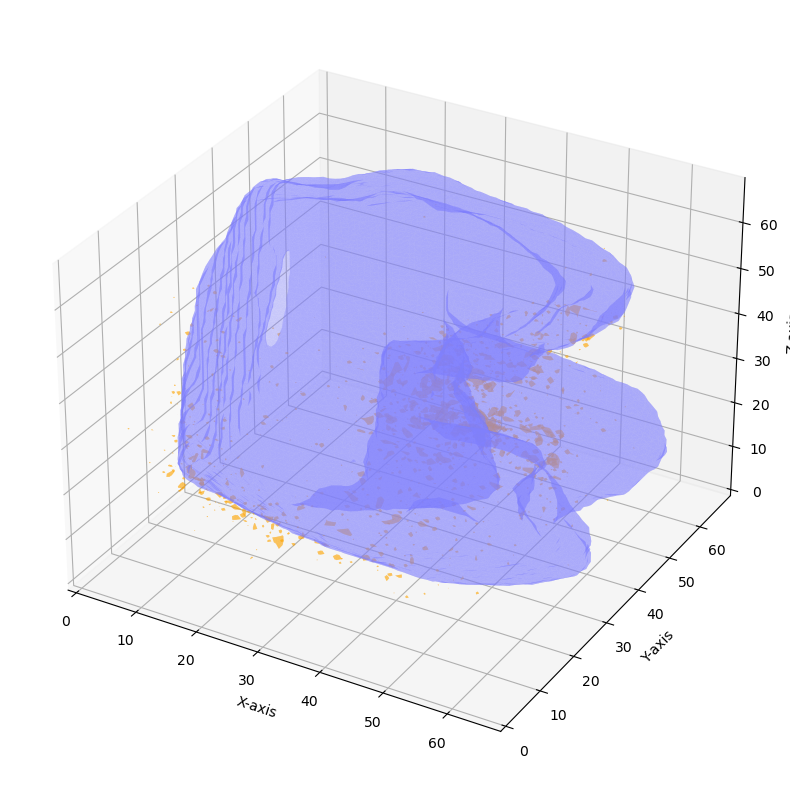

T2.1.npy


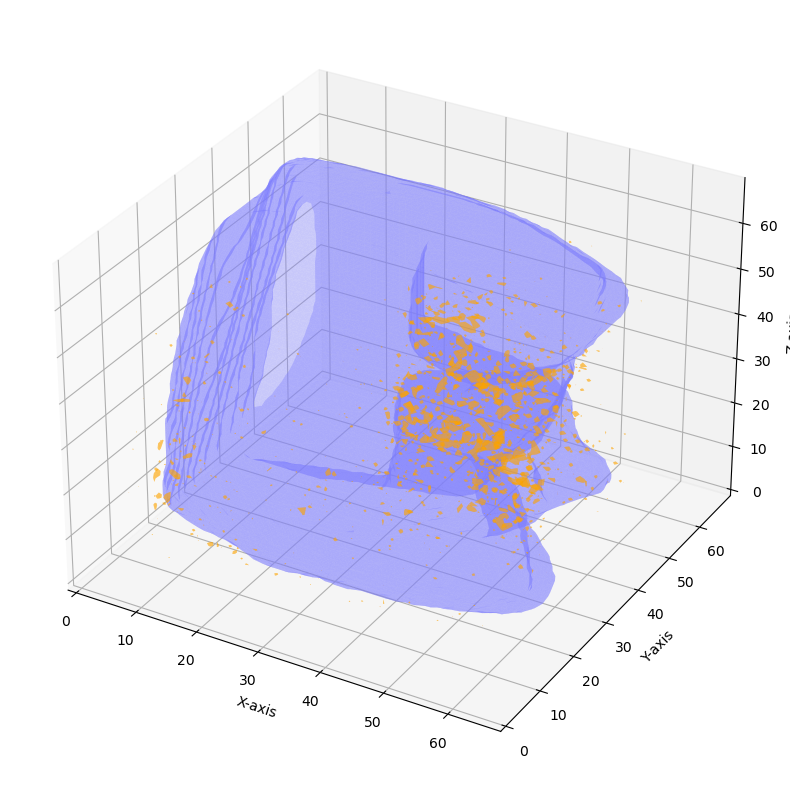

T2.2.npy


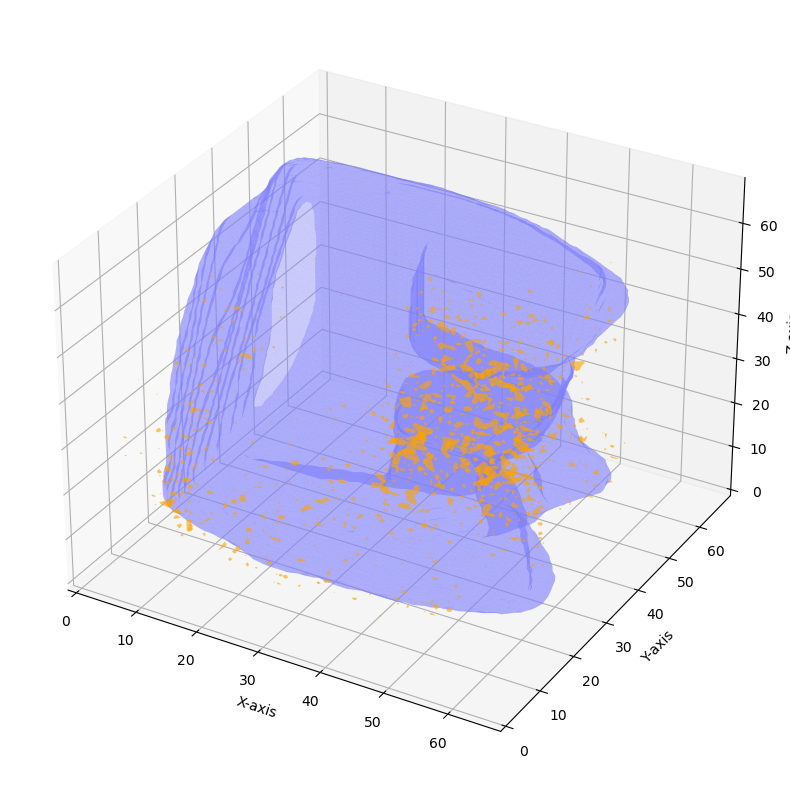

T3.1.npy


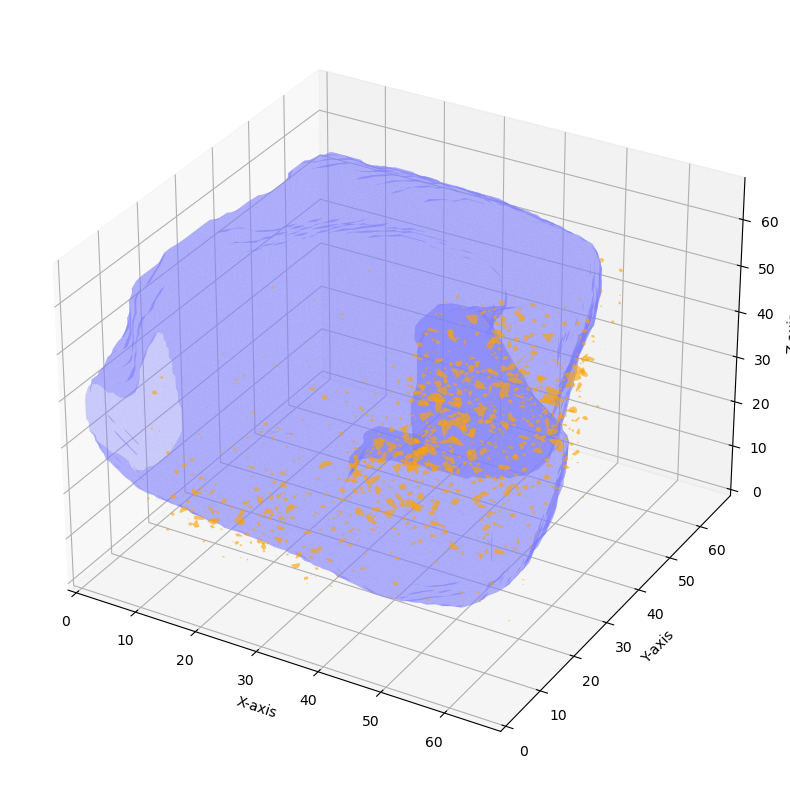

T3.4.npy


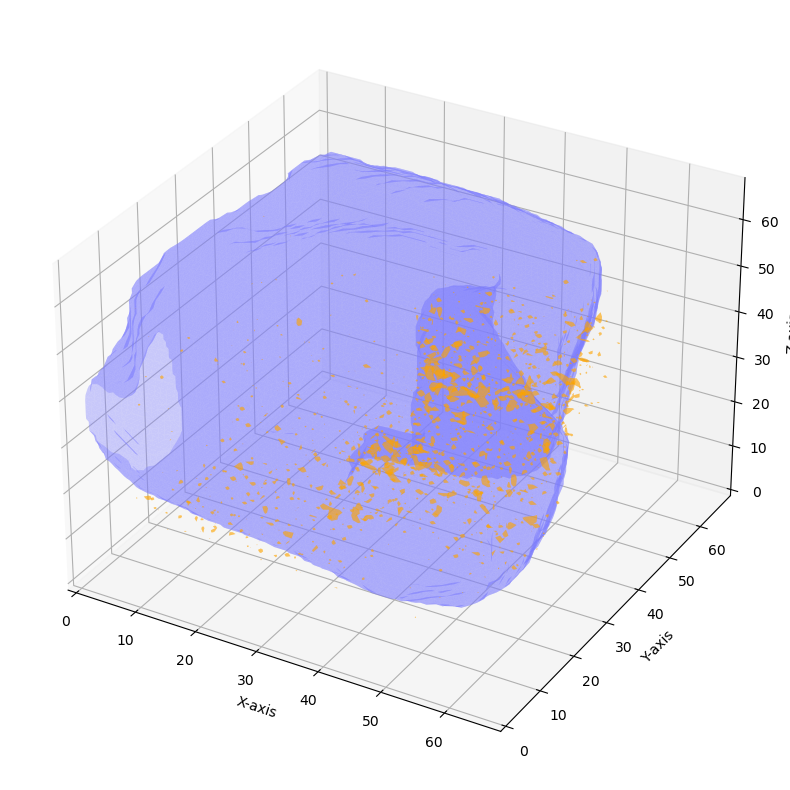

T4.1 (onlay).npy


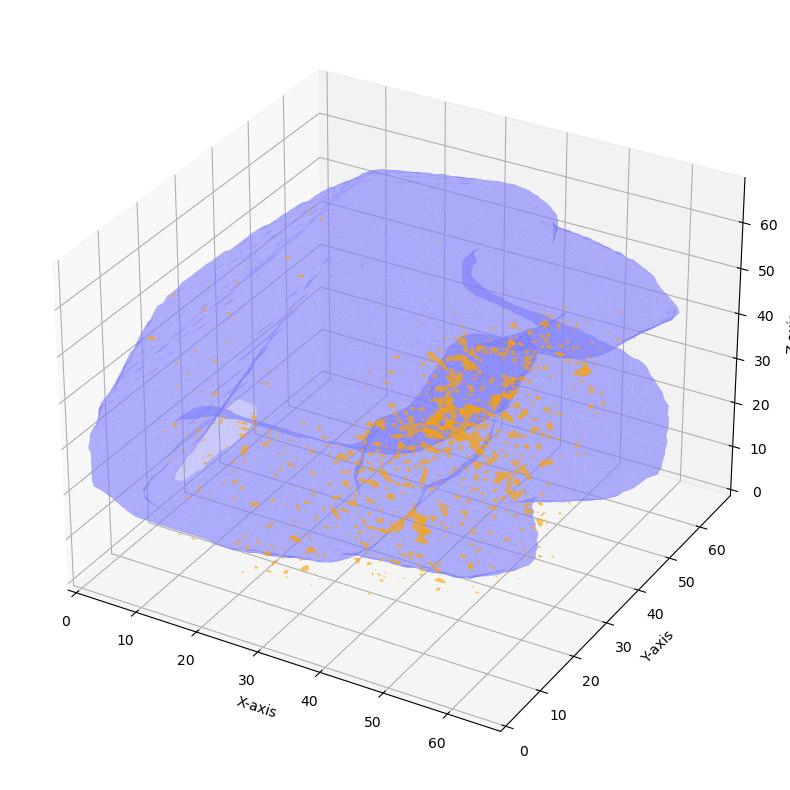

T5.1 (onlay).npy


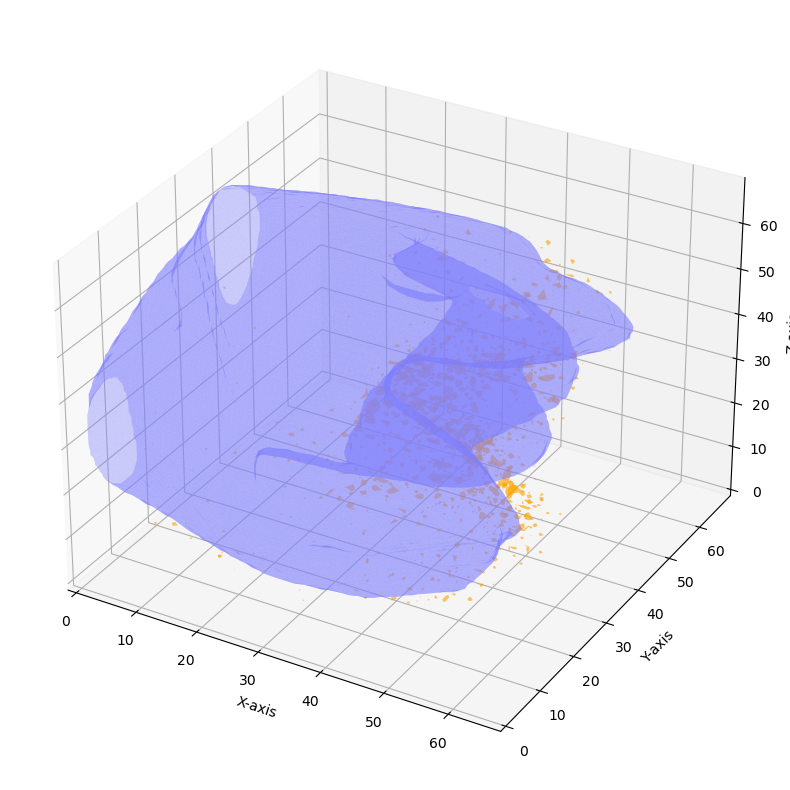

T5.3 (onlay).npy


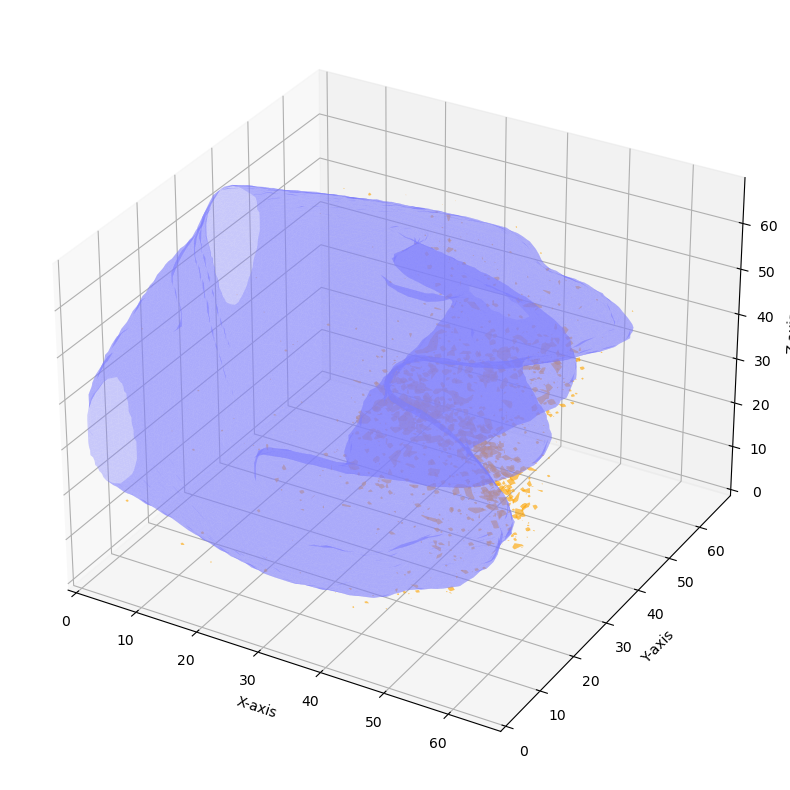

T6.1 (onlay).npy


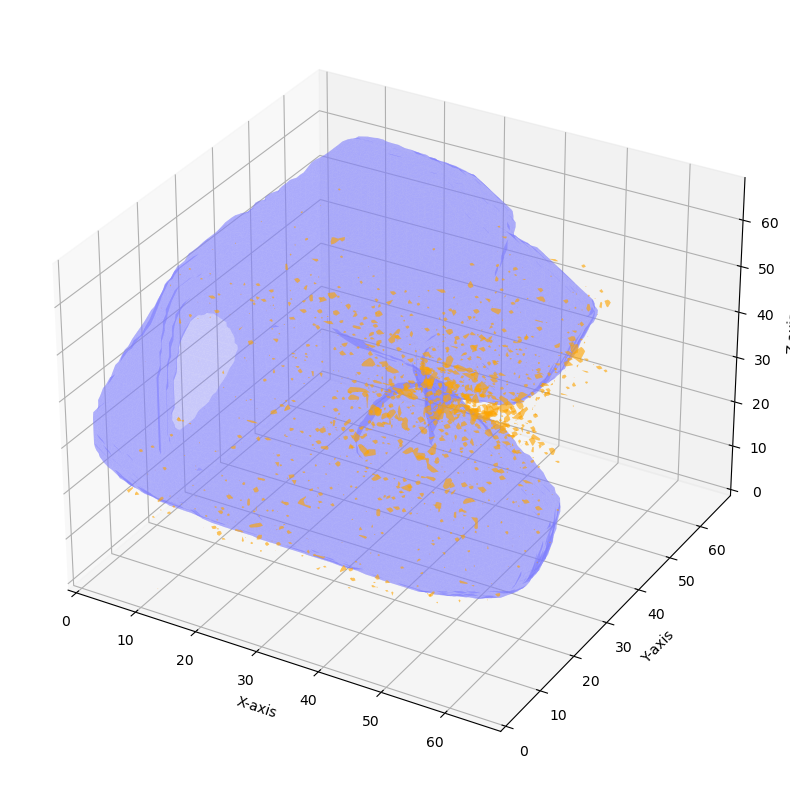

T6.5 (onlay).npy


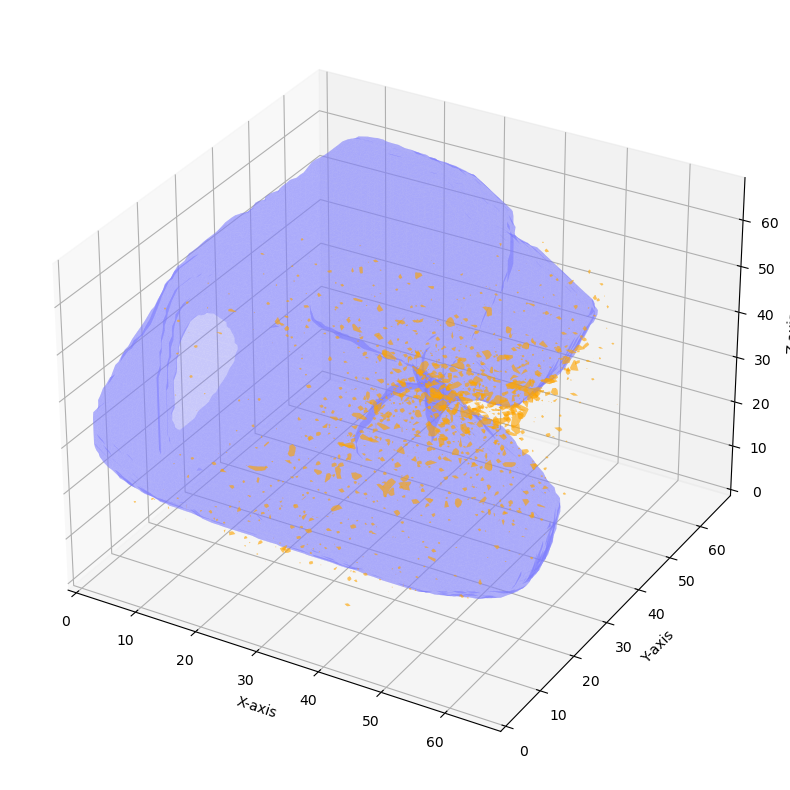

In [99]:
for data, target in validation_data_loader:
    data, target = data.to(device), target.to(device)
    generateAndSaveSaliencyMap(model, data, target)
